In [29]:
import numpy as np
import pyart
import warnings
from scipy.spatial import cKDTree
import multiprocessing as mp
from scipy.signal import savgol_filter
from scipy.interpolate import RegularGridInterpolator
from astropy.convolution import convolve
import matplotlib.pyplot as plt
import os, sys
# add location of local leroy modules to sys.path and import them
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('leroy.py'))))
import leroy 
import qc 

In [54]:
def get_leroy_roi(radar, coords, frac = 0.55):
    roi = 0
    rmax = np.sqrt(max(coords[0])**2 + max(coords[1])**2 + max(coords[2])**2)
    for i in range(radar.nsweeps):
        az = np.amax(np.radians(np.amax(np.diff(np.sort(radar.azimuth['data'][radar.get_slice(i)])))))
        r = frac * az * rmax
        if r > roi:
            roi = r
    return roi

def cressman_ppi_interp(radar, coords, field_names,Rc = None, k = 100, filter_its = 0, verbose = True, kernel = None, corr_lens = None):
    #mu =5, poly =3
    """
    Interpolate multiple fields from a radar object to a grid. This 
    is an implementation of the method described in Dahl et. al. (2019).
    
    Inputs:
    radar (Pyart object): radar to be interpolated
    coords (tuple): tuple of 3 1d arrays containing z, y, x of grid
    Rc (float): Cressman radius of interpolation
    field_names (list or string): field names in radar to interpolate
    k (int): max number of points within a radius of influence
    filter_its (int): number of filter iterations for the low-pass filter
    kwargs passed to the scipy.savgol_filter function
    
    """
    if type(field_names) != list:
        field_names = [field_names,]
    
    fields = []
    dims = [len(coord) for coord in coords]
    Z, Y, X = np.meshgrid(coords[0], coords[1], coords[2], indexing = 'ij')
    dz = np.mean(np.diff(np.sort(coords[0])))
    dy = np.mean(np.diff(np.sort(coords[1])))
    dx = np.mean(np.diff(np.sort(coords[2])))
    dh = np.mean((dy, dx))
    
    if Rc is None:
        Rc = get_leroy_roi(radar, coords, frac = 0.55)
        if verbose:
            print("Radius of influence set to {} m.".format(Rc))
    
    ppi_height = leroy.interpolate_to_ppi(radar, coords, Rc, 'height', k=k)
    

    
    if ppi_height.mask.sum() > 0:
        warnings.warn("""\n There are invalid height values which will 
        ruin the linear interpolation. This most likely means the radar
        doesnt cover the entire gridded domain""")
    
    if verbose:
        print('Interpolating...')
    for field in field_names:
        ppis = leroy.interpolate_to_ppi(radar, coords, Rc, field, k=k)
        grid = leroy.interp_along_axis(ppis.filled(np.nan), ppi_height, Z, axis=0, method='linear')
        
        
        if filter_its > 0:
            if verbose:
                print('Filtering...')
                
            if kernel is None:
                if corr_lens == None:
                    raise NotImplementedError("""You must either input a convolution kernel 
                        ('kernel') or some correlation lengths ('corr_len').""")
                v_window = int(np.ceil(corr_lens[0]/dz) // 2 * 2 + 1)
                h_window = int(np.ceil(corr_lens[1]/dh) // 2 * 2 + 1)
                kernel =  np.ones((v_window, h_window, h_window))/np.float(v_window * h_window * h_window)
                
            smooth = grid.copy()
            for i in range(filter_its):
                smooth = convolve(smooth, kernel, boundary = 'extend')
                
            grid = smooth.copy()
            
        fields.append(np.ma.masked_array(grid, mask = np.isnan(grid)))
    if verbose:
        print('Done!')
    if len(fields) > 1:
        return fields
    else:
        return fields[0]

In [187]:
field = 'corrected_reflectivity'
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    radar = pyart.io.read("/g/data/hj10/cpol/cpol_level_1b/v2020/ppi/2002/20021102/twp10cpolppi.b1.20021102.150000.nc")
    radar.add_field_like(field, field+'_original', radar.fields[field]['data'])
    radar = qc.mask_invalid_data(radar, 'corrected_reflectivity', add_to = [field], min_field = 5, min_area = 50, return_smooth = False)

In [188]:
gs = (31, 201, 201)
gb = ((0, 15000), (-100000,100000),(-100000,100000))
center_pos = (0,0,0)
lon0, lat0 = radar.longitude['data'][0], radar.latitude['data'][0]

x = np.linspace(gb[2][0],gb[2][1], gs[2])
y = np.linspace(gb[1][0],gb[1][1], gs[1])
z = np.linspace(gb[0][0],gb[0][1], gs[0])
coords = (z-center_pos[0], y-center_pos[1], x-center_pos[2])

def leroy_grid(radar,coords, field, **kwargs):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        return cressman_ppi_interp(radar, coords, field, k=200, verbose=True, **kwargs)


In [189]:
f_orig   = leroy_grid(radar, coords, field,filter_its = 0)
f_smooth = leroy_grid(radar, coords, field,filter_its = 2, corr_lens = (800, 2000))

Radius of influence set to 2389.0342400103436 m.
Interpolating...
Done!
Radius of influence set to 2389.0342400103436 m.
Interpolating...
Filtering...
Done!


/home/564/jb2354/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.
/home/564/jb2354/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


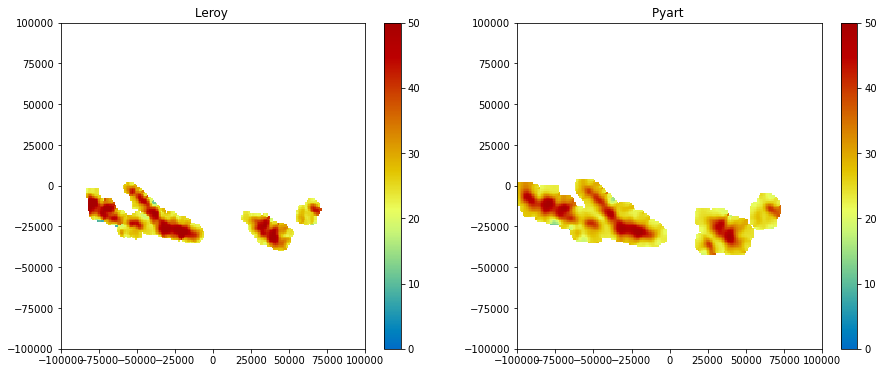

In [190]:
zidx = 2
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(121)
m = ax.pcolormesh(x,y,f_orig[zidx,...], cmap ='pyart_HomeyerRainbow', vmin = 0, vmax = 50)
plt.colorbar(m)
ax.set_title('Original ')


ax = fig.add_subplot(122)
m = ax.pcolormesh(x,y,f_smooth[zidx,...], cmap ='pyart_HomeyerRainbow', vmin = 0, vmax = 50)
plt.colorbar(m)
ax.set_title('Smoothed ')
plt.show()

/home/564/jb2354/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.
/home/564/jb2354/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


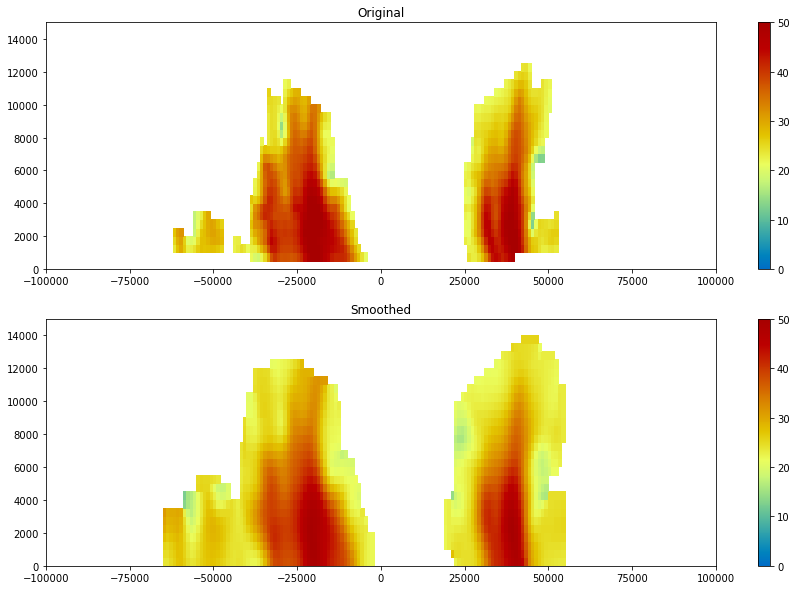

In [194]:
yidx = 70
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(211)
m = ax.pcolormesh(x,z,f_orig[:,yidx,:], cmap ='pyart_HomeyerRainbow', vmin = 0, vmax = 50)
plt.colorbar(m)
ax.set_title('Original')
ax = fig.add_subplot(212)
m = ax.pcolormesh(x,z,f_smooth[:,yidx,:], cmap ='pyart_HomeyerRainbow', vmin = 0, vmax = 50)
plt.colorbar(m)
ax.set_title('Smoothed')

plt.show()